In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torchio nibabel matplotlib monai lightning
!pip install segmentation-models-pytorch==0.3.3
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 

In [2]:
import os
import torch
import numpy as np
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchio as tio
from torch.utils.data import random_split, DataLoader
import torchvision.transforms.v2 as T
import random
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import cv2
from skimage import exposure
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm
from torchvision.utils import save_image
import torch.nn.functional as F
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
def proprocess_ct( ct_slice):
        # --- HU Windowing ---
        ct_slice = np.clip(ct_slice, -150, 250)

        # --- Normalization ---
        ct_slice = (ct_slice - ct_slice.mean()) / (ct_slice.std() + 1e-8)
        ct_slice = np.clip(ct_slice, -3, 3)

        # --- Denoising (Median Filter) ---
        ct_slice = ndi.median_filter(ct_slice, size=3)

        # # --- Histogram Equalization or CLAHE ---
        ct_slice =  exposure.equalize_adapthist(ct_slice / np.max(ct_slice), clip_limit=0.03)
        ct_slice = (ct_slice - 0.5) / 0.5  # scale to [-1, 1]

        return ct_slice
def preprocess_ct( ct_slice):
    # --- HU Windowing ---
    ct_slice = np.clip(ct_slice, -150, 250)

    # --- Normalization ---
    ct_slice = (ct_slice - ct_slice.mean()) / (ct_slice.std() + 1e-8)
    ct_slice = np.clip(ct_slice, -3, 3)

    # --- Denoising (Median Filter) ---
    ct_slice = ndi.median_filter(ct_slice, size=3)

    # # --- Histogram Equalization or CLAHE ---
    ct_slice =  exposure.equalize_adapthist(ct_slice / np.max(ct_slice), clip_limit=0.03)
    ct_slice = (ct_slice - 0.5) / 0.5  # scale to [-1, 1]

    return ct_slice

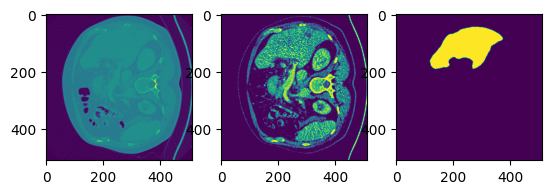

In [4]:
ct = nib.load("/kaggle/input/aio2025liverseg/train/volume/volume-070.nii").get_fdata()
ct_slice = ct[:, :, 500].astype(np.float32)
mask = nib.load("/kaggle/input/aio2025liverseg/train/segmentation/segmentation-070.nii").get_fdata()
mask_slice = (mask[:, :, 500] > 0).astype(np.float32)
plt.subplot(1,3,1)
plt.imshow(ct_slice)
plt.subplot(1,3,2)
plt.imshow(preprocess_ct(ct_slice))
plt.subplot(1,3,3)
plt.imshow(mask_slice)



In [30]:
def preprocess_and_save(ct_path, mask_path, out_ct_dir, out_mask_dir, start_idx=0):
    ct_vol = nib.load(ct_path).get_fdata(dtype=np.float32)
    mask_vol = nib.load(mask_path).get_fdata(dtype=np.float32)

    os.makedirs(out_ct_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    saved_count = start_idx
    for s_idx in range(ct_vol.shape[2]):
        mask_slice = mask_vol[:, :, s_idx]
        if not np.any(mask_slice > 0):
            ct_slice = ct_vol[:, :, s_idx]
            ct_slice = preprocess_ct(ct_slice)

            # Resize
            ct_slice = torch.from_numpy(ct_slice).unsqueeze(0)
            # ct_slice = F.interpolate(ct_slice.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
            mask_slice = torch.from_numpy(mask_slice).unsqueeze(0)
            # mask_slice = F.interpolate(mask_slice.unsqueeze(0), size=(256, 256), mode='nearest').squeeze(0)

            # Convert to numpy
            ct_slice = ct_slice.squeeze().cpu().numpy()
            mask_slice = mask_slice.squeeze().cpu().numpy()

            # Save
            np.savez_compressed(os.path.join(out_ct_dir, f"{saved_count:06d}.npy"), ct_slice)
            np.savez_compressed(os.path.join(out_mask_dir, f"{saved_count:06d}.npy"), mask_slice)
            saved_count += 1
    return saved_count

# Paths
ct_root = "/kaggle/input/aio2025liverseg/train/volume"
mask_root = "/kaggle/input/aio2025liverseg/train/segmentation"
out_ct_dir = "/kaggle/working/dataset/train/ct/non_liver"
out_mask_dir = "/kaggle/working/dataset/train/mask/non_liver"

ct_files = sorted([os.path.join(ct_root, f) for f in os.listdir(ct_root) if f.endswith((".nii", ".nii.gz"))])
mask_files = sorted([os.path.join(mask_root, f) for f in os.listdir(mask_root) if f.endswith((".nii", ".nii.gz"))])

# Global counter
global_count = 0
# for ct_path, mask_path in tqdm(zip(ct_files, mask_files), total=len(ct_files)):
#     global_count = preprocess_and_save(ct_path, mask_path, out_ct_dir, out_mask_dir, start_idx=global_count)

print(f"Total slices saved: {global_count}")


100%|██████████| 80/80 [20:18<00:00, 15.23s/it]

Total slices saved: 11313


In [31]:
def preprocess_and_save_test(ct_path, out_ct_dir):
    ct_vol = nib.load(ct_path).get_fdata(dtype=np.float32)

    os.makedirs(out_ct_dir, exist_ok=True)
    folder_volume = ct_path.split("/")[-1].split(".")[0]
    os.makedirs(os.path.join(out_ct_dir, folder_volume), exist_ok=True)

    saved_count = 0
    for s_idx in range(ct_vol.shape[2]):
        ct_slice = ct_vol[:, :, s_idx]
        ct_slice = preprocess_ct(ct_slice)

        # Resize
        ct_slice = torch.from_numpy(ct_slice).unsqueeze(0)
        # ct_slice = F.interpolate(ct_slice.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

        # Convert to numpy
        ct_slice = ct_slice.squeeze().cpu().numpy()

        # Save
        np.savez_compressed(os.path.join(out_ct_dir, folder_volume,f"{saved_count:06d}.npy"), ct_slice)
        saved_count += 1
    return saved_count

# Paths
ct_root = "/kaggle/input/aio2025liverseg/test"
out_ct_dir = "/kaggle/working/dataset/test"

ct_files = sorted([os.path.join(ct_root, f) for f in os.listdir(ct_root) if f.endswith((".nii", ".nii.gz"))])

# Global counter
global_count = 0
# for ct_path in tqdm(ct_files, total=len(ct_files)):
#     global_count += preprocess_and_save_test(ct_path, out_ct_dir)

print(f"Total slices saved: {global_count}")


100%|██████████| 51/51 [29:23<00:00, 34.57s/it]

Total slices saved: 24034


In [5]:
class LiverTrainingDataset(Dataset):
    def __init__(self, root, mode="train"):
        self.root = root
        self.ct_paths = sorted([os.path.join(root, "ct", p) for p in os.listdir(os.path.join(root, "ct"))])
        self.mask_paths = sorted([os.path.join(root, "mask", p) for p in os.listdir(os.path.join(root, "mask"))])
    def __len__(self):
        return len(self.ct_paths)
    def __getitem__(self, idx):
        ct = np.load(self.ct_paths[idx])["arr_0"].astype(np.float32)
        ct = torch.from_numpy(ct).unsqueeze(0)

        mask = np.load(self.mask_paths[idx])["arr_0"].astype(np.float32)
        mask = (mask > 0).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        return ct, mask
        
    
        

In [6]:
class LiverTestingDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.volume_dirs = sorted([os.path.join(root, p) for p in os.listdir(os.path.join(root))])
    def __len__(self):
        return len(self.volume_dirs)
    def __getitem__(self, idx):
        volume_dir = self.volume_dirs[idx]
        slice_files = sorted([
            os.path.join(volume_dir, f)
            for f in os.listdir(volume_dir)
            if f.endswith(".npz")
        ])

        # --- Load and preprocess all slices ---
        slices = []
        for slice_path in slice_files:
            ct_slice = np.load(slice_path)["arr_0"].astype(np.float32)
            ct_slice = torch.from_numpy(ct_slice)
            slices.append(ct_slice)

        # Stack into [1, D, H, W]
        volume = torch.stack(slices, dim=0)
        volume = volume.unsqueeze(0)  # [1, D, H, W]

        return volume
    
        

In [7]:
dataset = LiverTrainingDataset("/kaggle/working/dataset/train")
val_ratio = 0.2  # 20% validation
train_size = int((1 - val_ratio) * len(dataset))
val_size = len(dataset) - train_size

# Split into train/val
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = LiverTestingDataset("/kaggle/working/dataset/test")

In [8]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

9050
2263
51


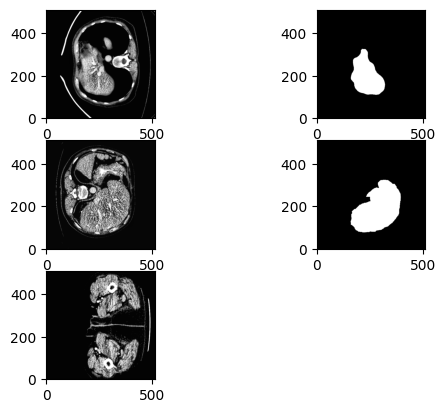

In [9]:
idx = 50

plt.subplot(3,2,1)
plt.imshow(train_dataset[idx][0].squeeze(0), cmap='gray', origin='lower')
plt.subplot(3,2,2)
plt.imshow(train_dataset[idx][1].squeeze(0), cmap='gray', origin='lower')
plt.subplot(3,2,3)
plt.imshow(val_dataset[idx][0].squeeze(0), cmap='gray', origin='lower')
plt.subplot(3,2,4)
plt.imshow(val_dataset[idx][1].squeeze(0), cmap='gray', origin='lower')
plt.subplot(3,2,5)
plt.imshow(test_dataset[idx][:,0,:,:].squeeze(0), cmap='gray', origin='lower')

In [10]:
# CREATE DATALOADER

train_loader = DataLoader(
    train_dataset,
    batch_size=12,     # depending on your GPU memory
    shuffle=True,
    num_workers=2,    # or 0 if you're on Kaggle CPU mode
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=12,     # depending on your GPU memory
    shuffle=False,
    num_workers=2,    # or 0 if you're on Kaggle CPU mode
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,     # depending on your GPU memory
    shuffle=False,
    num_workers=2,    # or 0 if you're on Kaggle CPU mode
    pin_memory=True
)


In [11]:
# TEST DATALOADER
print("TRAIN LOADER: ")
ct, mask = next(iter(train_loader))
print(ct.shape, mask.shape)
print("VALIDATION LOADER: ")
ct, mask = next(iter(val_loader))
print(ct.shape, mask.shape)
print("TEST LOADER: ")
ct_test = next(iter(test_loader))
print(ct_test.shape)


TRAIN LOADER: 
torch.Size([12, 1, 512, 512]) torch.Size([12, 1, 512, 512])
VALIDATION LOADER: 
torch.Size([12, 1, 512, 512]) torch.Size([12, 1, 512, 512])
TEST LOADER: 
torch.Size([1, 1, 677, 512, 512])


In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]
def intersectionAndUnion(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        intersection = (probs * targets).sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (
            probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.smooth
        )
        return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, logits, targets):
        return self.bce(logits, targets) + self.dice(logits, targets)
        
class BCEDiceLossPaper(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice


class LovaszHingeLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        input = input.squeeze(1)
        target = target.squeeze(1)
        loss = lovasz_hinge(input, target, per_image=True)

        return loss


In [13]:
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)

In [22]:
# Example input: 1 channel, 512x512, batch size 1
x = np.ones([1, 3, 512, 512], dtype=np.float32)  # add batch dim
x = torch.from_numpy(x)  # convert to torch.Tensor

model_Unext = UNext(num_classes=1)
model_Unext.eval()

with torch.no_grad():
    y = model_Unext(x)

print(y.shape)

torch.Size([1, 1, 512, 512])


In [23]:
class UNextLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4, classes=1):
        super().__init__()
        self.model = model
        self.criterion = BCEDiceLossPaper()
        self.lr = lr
        self.classes = classes

        # Track metrics
        self.register_buffer('train_intersection', torch.zeros(classes))
        self.register_buffer('train_union', torch.zeros(classes))
        self.register_buffer('train_target', torch.zeros(classes))

        self.register_buffer('val_intersection', torch.zeros(classes))
        self.register_buffer('val_union', torch.zeros(classes))
        self.register_buffer('val_target', torch.zeros(classes))

        # self.register_buffer('test_intersection', torch.zeros(classes))
        # self.register_buffer('test_union', torch.zeros(classes))
        # self.register_buffer('test_target', torch.zeros(classes))

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.repeat(1,3,1,1)
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        with torch.no_grad():
            preds = (torch.sigmoid(y_hat) > 0.5).float()
            y_flat = y.float()
            
            # Compute Dice per batch
            intersection = (preds * y_flat).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + y_flat.sum(dim=(1, 2, 3))
            dice_batch = (2 * intersection + 1e-5) / (union + 1e-5)
            dice_epoch = dice_batch.mean()
            
            # Log batch Dice
            self.log('train_mDice', dice_epoch, on_step=True, on_epoch=True, prog_bar=True)
    
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.repeat(1, 3, 1, 1)
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
    
        with torch.no_grad():
            probs = torch.sigmoid(y_hat)
            preds = (probs > 0.5).float()
            intersection = (preds * y).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + y.sum(dim=(1, 2, 3))
            dice_batch = (2 * intersection + 1e-5) / (union + 1e-5)
            self.log('val_mDice', dice_batch.mean(), prog_bar=True, on_step=True, on_epoch=True)
    
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def on_validation_epoch_end(self):
        # No need to manually aggregate metrics anymore
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        
    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_hat = self._get_logits(x)
    #     loss = self.criterion(y_hat, y)

    #     with torch.no_grad():
    #         preds = (torch.sigmoid(y_hat) > 0.5).float().squeeze(1)
    #         intersection, union, target = intersectionAndUnion(
    #             preds, y.detach().squeeze(1).float(), self.classes
    #         )
    #         self.test_intersection += intersection
    #         self.test_union += union
    #         self.test_target += target

    #     self.log('epolar_test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    #     return loss

    # def on_test_epoch_end(self):
    #     iou_class = self.test_intersection / (self.test_union + 1e-10)
    #     dice_class = (2 * self.test_intersection) / (self.test_intersection + self.test_union + 1e-10)
    #     self.log('epolar_test_mIoU', torch.mean(iou_class), prog_bar=True)
    #     self.log('epolar_test_mDice', torch.mean(dice_class), prog_bar=True)

    #     self.test_intersection.zero_()
    #     self.test_union.zero_()
    #     self.test_target.zero_()

In [12]:
class UnetPlusPlusLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4, classes=1):
        super().__init__()
        self.model = model
        self.criterion = BCEDiceLossPaper()
        self.lr = lr
        self.classes = classes

        # Track metrics
        self.register_buffer('train_intersection', torch.zeros(classes))
        self.register_buffer('train_union', torch.zeros(classes))
        self.register_buffer('train_target', torch.zeros(classes))

        self.register_buffer('val_intersection', torch.zeros(classes))
        self.register_buffer('val_union', torch.zeros(classes))
        self.register_buffer('val_target', torch.zeros(classes))

        # self.register_buffer('test_intersection', torch.zeros(classes))
        # self.register_buffer('test_union', torch.zeros(classes))
        # self.register_buffer('test_target', torch.zeros(classes))

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        with torch.no_grad():
            preds = (torch.sigmoid(y_hat) > 0.5).float().squeeze(1)
            intersection, union, target = intersectionAndUnion(
                preds, y.detach().squeeze(1).float(), self.classes
            )
            self.train_intersection += intersection
            self.train_union += union
            self.train_target += target

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        iou_class = self.train_intersection / (self.train_union + 1e-10)
        dice_class = (2 * self.train_intersection) / (self.train_intersection + self.train_union + 1e-10)
        self.log('train_mIoU', torch.mean(iou_class), prog_bar=True)
        self.log('train_mDice', torch.mean(dice_class), prog_bar=True)

        self.train_intersection.zero_()
        self.train_union.zero_()
        self.train_target.zero_()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        with torch.no_grad():
            preds = (torch.sigmoid(y_hat) > 0.5).float().squeeze(1)
            intersection, union, target = intersectionAndUnion(
                preds, y.detach().squeeze(1).float(), self.classes
            )
            self.val_intersection += intersection
            self.val_union += union
            self.val_target += target

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        iou_class = self.val_intersection / (self.val_union + 1e-10)
        dice_class = (2 * self.val_intersection) / (self.val_intersection + self.val_union + 1e-10)
        self.log('val_mIoU', torch.mean(iou_class), prog_bar=True)
        self.log('val_mDice', torch.mean(dice_class), prog_bar=True)

        self.val_intersection.zero_()
        self.val_union.zero_()
        self.val_target.zero_()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        
    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_hat = self._get_logits(x)
    #     loss = self.criterion(y_hat, y)

    #     with torch.no_grad():
    #         preds = (torch.sigmoid(y_hat) > 0.5).float().squeeze(1)
    #         intersection, union, target = intersectionAndUnion(
    #             preds, y.detach().squeeze(1).float(), self.classes
    #         )
    #         self.test_intersection += intersection
    #         self.test_union += union
    #         self.test_target += target

    #     self.log('epolar_test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    #     return loss

    # def on_test_epoch_end(self):
    #     iou_class = self.test_intersection / (self.test_union + 1e-10)
    #     dice_class = (2 * self.test_intersection) / (self.test_intersection + self.test_union + 1e-10)
    #     self.log('epolar_test_mIoU', torch.mean(iou_class), prog_bar=True)
    #     self.log('epolar_test_mDice', torch.mean(dice_class), prog_bar=True)

    #     self.test_intersection.zero_()
    #     self.test_union.zero_()
    #     self.test_target.zero_()

In [15]:
# WANDB
student_id = "10423057"  # TODO: replace with your student ID
api_key = os.environ.get("WANDB_API_KEY", "83f4544a22543e319c6009abceaac90b634c68a3")  # configure your wandb key here

if api_key == "":
    raise ValueError("Please set your wandb key in the code or in the environment variable WANDB_API_KEY")
else:
    print("WandB API key is set. Proceeding with login...")
    
wandb.login(key=api_key)

WandB API key is set. Proceeding with login...


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 10423057 (10423057-vietnamese-german-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [16]:
!mkdir /kaggle/working/checkpoints/unext

mkdir: cannot create directory ‘/kaggle/working/checkpoints/unext’: File exists


In [33]:
# FIND LATEST CHECKPOINT
model_name = "unext"
checkpoint_dir = f"/kaggle/working/checkpoints/{model_name}"
ckpt_path = None

if os.path.exists(checkpoint_dir):
    ckpts = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
    if ckpts:
        ckpt_path = max(ckpts, key=os.path.getctime)  # latest file by creation time

print("Resuming from checkpoint:" if ckpt_path else "No checkpoint found.", ckpt_path)



Resuming from checkpoint: /kaggle/working/checkpoints/unext/last.ckpt


In [24]:
# import shutil
# import os

# folder = "/kaggle/working/checkpoints/unext"  # change to your folder

# # Delete everything inside the folder
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.remove(file_path)  # remove file or link
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)  # remove folder recursively
#     except Exception as e:
#         print(f"Failed to delete {file_path}. Reason: {e}")

In [26]:
# CHECKPOINT
wandb_logger = WandbLogger(project='lts_version2.0', name=model_name)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'/kaggle/working/checkpoints/{model_name}',
    filename='unext-{epoch:02d}-{unext_val_loss:.4f}',
    save_last=True,
    save_top_k=2,
    monitor='val_mDice',
    mode='max'
)

In [31]:
# TRAINER
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,    
    callbacks=[checkpoint_callback],
    logger=wandb_logger,
    log_every_n_steps=5,
    fast_dev_run = False,
    enable_checkpointing=True,
    accumulate_grad_batches=2,
    gradient_clip_val=1.0,
)


In [32]:
# TRAINING
# base_model = smp.UnetPlusPlus(
#     encoder_name="resnet34",        # backbone encoder
#     encoder_weights="imagenet",     # use pretrained ImageNet weights
#     in_channels=1,                  # grayscale inputa
#     classes=1,                      # binary output
# )
base_model = UNext(1)
model = UNextLightning(base_model, lr=1e-4)
trainer.fit(model, train_loader, val_loader, ckpt_path = ckpt_path)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1055, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py", line 216, in run
    self.advance()
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py", line 458, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.11

TypeError: object of type 'NoneType' has no len()

In [55]:
ckpt_path

'/kaggle/working/checkpoints/unext/last.ckpt'

In [56]:
!ls /kaggle/working/checkpoints/unext


 last.ckpt
'unext-epoch=29-unext_val_loss=0.0000.ckpt'
'unext-epoch=31-unext_val_loss=0.0000.ckpt'


In [35]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_test = UNextLightning.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    model = base_model, 
    lr=1e-4
).to(device)


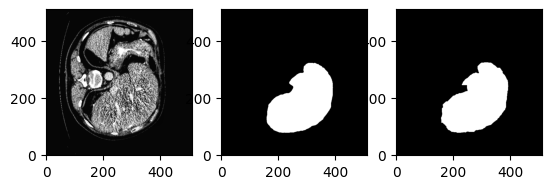

In [45]:
model_test.eval()
idx = 50
test_point =  val_dataset[idx][0].repeat(3,1,1).unsqueeze(0).to(device)
plt.subplot(1,3,1)
plt.imshow(val_dataset[idx][0].squeeze(0), cmap='gray', origin='lower')
plt.subplot(1,3,2)
plt.imshow((torch.sigmoid((model_test(test_point) > 0).squeeze(0))).cpu().detach().numpy().squeeze(0), cmap='gray', origin='lower')
plt.subplot(1,3,3)
plt.imshow(val_dataset[idx][1].squeeze(0), cmap='gray', origin='lower')

In [38]:
test_point.shape

torch.Size([1, 3, 512, 512])

In [40]:
def rle_encode(mask: np.ndarray) -> str:
    """
    Run-length encode a 2D binary mask (1 for foreground, 0 for background)
    Empty mask -> '1 0'.
    """
    assert mask.ndim == 2, "rle_encode expects a 2D mask"
    pixels = mask.astype(np.uint8).flatten(order='F')  # column-major
    if pixels.max() == 0:
        return "1 0"
    # Pad with zeros at both ends to catch transitions cleanly
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))


In [59]:
import pandas as pd
from tqdm import tqdm

submission_rows = []

for vol_idx in tqdm(range(len(test_dataset))):
    vol = test_dataset[vol_idx]
    vol_idx += 80
    preds = []
    for slice_idx, i in enumerate(vol.permute(1,0,2,3)):
        i = i.repeat(3,1,1)
        with torch.no_grad():
            pred = model_test(i.unsqueeze(0).to(device)).squeeze()
        pred = torch.sigmoid(pred)          # probabilities [0,1]
        pred = pred.cpu().numpy()
        pred = (pred > 0.65).astype(np.float32)
        # if pred.shape != (256,256):
        #     print(pred.shape)
        # pred = cv2.resize(pred, (512, 512), interpolation=cv2.INTER_NEAREST)
        if pred.shape != (512,512):
            print(pred.shape)
        preds.append(pred)
    preds = np.array(preds)
    preds_cleared = keep_largest_3d_region(preds)
    for idx, pred_cleared in enumerate(preds_cleared):
        # pred_cleared = keep_largest_component(pred_cleared)
        rle_pred =  rle_encode(pred_cleared)
        # Construct submission ID
        submission_id = f"cell_{vol_idx}_{idx}"
        submission_rows.append({
            "id": submission_id,
            "rle": rle_pred
        })

# Create submission DataFrame
submission_df = pd.DataFrame(submission_rows)
# Save CSV
submission_df.to_csv("submission.csv", index=False)
print("Saved submission.csv with", len(submission_df), "rows")



100%|██████████| 51/51 [12:29<00:00, 14.69s/it]


Saved submission.csv with 24034 rows


In [60]:
df = pd.read_csv("submission.csv")
print("Total rows:", len(df))


Total rows: 24034


In [61]:
with open("submission.csv", "r") as f:
    total_lines = sum(1 for line in f)

print("Total lines including header:", total_lines)
print("Total data rows:", total_lines - 1)  # subtract 1 for header


Total lines including header: 24035
Total data rows: 24034



  0%|          | 0/51 [00:00<?, ?it/s]


🧠 Processing Volume 80 ...


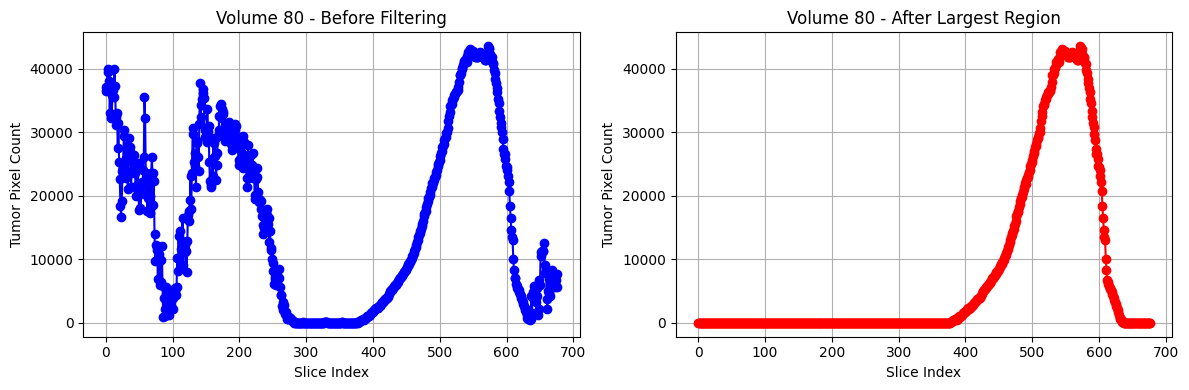


  2%|▏         | 1/51 [00:26<21:53, 26.28s/it]


🧠 Processing Volume 81 ...


  2%|▏         | 1/51 [00:42<35:13, 42.26s/it]


KeyboardInterrupt: 

In [58]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for vol_idx, vol in enumerate(tqdm(test_loader)):
    vol_idx += 80  # optional offset

    vol = vol.squeeze(0)  # remove batch dim [1, C, D, H, W] → [C, D, H, W]
    preds = []

    print(f"\n🧠 Processing Volume {vol_idx} ...")

    # iterate over slices: [C, D, H, W] → [D, C, H, W]
    for slice_ in vol.permute(1, 0, 2, 3):
        slice_ = slice_.repeat(3,1,1)
        with torch.no_grad():
            pred = model_test(slice_.unsqueeze(0).to(device)).squeeze()
        pred = torch.sigmoid(pred)
        pred = pred.cpu().numpy()
        pred = (pred > 0.6).astype(np.float32)

        # resize to consistent size
        if pred.shape != (512, 512):
            pred = cv2.resize(pred, (512, 512), interpolation=cv2.INTER_NEAREST)

        preds.append(pred)

    preds = np.array(preds)

    # Before clearing: sum tumor pixels per slice
    tumor_counts_before = [np.sum(p) for p in preds]

    # Apply largest region filter
    cleared_preds = keep_largest_3d_region(preds)
    tumor_counts_after = [np.sum(p) for p in cleared_preds]

    # Plot before and after
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(tumor_counts_before)), tumor_counts_before, marker='o', linestyle='-', color='b')
    plt.title(f"Volume {vol_idx} - Before Filtering")
    plt.xlabel("Slice Index")
    plt.ylabel("Tumor Pixel Count")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(len(tumor_counts_after)), tumor_counts_after, marker='o', linestyle='-', color='r')
    plt.title(f"Volume {vol_idx} - After Largest Region")
    plt.xlabel("Slice Index")
    plt.ylabel("Tumor Pixel Count")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [41]:
vol_1 = test_dataset[7]
preds = []
for i in tqdm(vol_1.permute(1,0,2,3)):
    with torch.no_grad():
        pred = model_test(i.unsqueeze(0).to(device)).squeeze()
    pred = torch.sigmoid(pred)
    pred = pred.cpu().numpy()
    pred = (pred > 0.5).astype(np.float32)
    # if pred.shape != (256,256):
    #         print(pred.shape)
    # pred = cv2.resize(pred, (512, 512), interpolation=cv2.INTER_NEAREST)
    if pred.shape != (512,512):
        print(pred.shape)
    preds.append(pred)
    

100%|██████████| 391/391 [00:08<00:00, 45.60it/s]


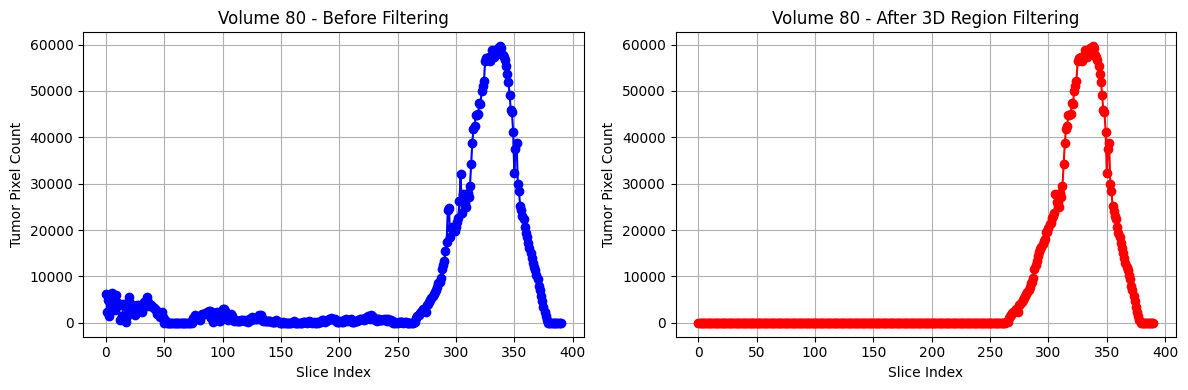

In [42]:
# After you compute preds (a list of 2D masks)
preds = np.array(preds)

# Before 3D cleaning
tumor_counts_before = [np.sum(p) for p in preds]

# Apply 3D connected-component filter
cleared_preds = keep_largest_3d_region(preds, threshold=0.5)
tumor_counts_after = [np.sum(p) for p in cleared_preds]

# Plot before/after comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(tumor_counts_before)), tumor_counts_before, marker='o', color='b')
plt.title(f"Volume {80} - Before Filtering")
plt.xlabel("Slice Index"); plt.ylabel("Tumor Pixel Count"); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(tumor_counts_after)), tumor_counts_after, marker='o', color='r')
plt.title(f"Volume {80} - After 3D Region Filtering")
plt.xlabel("Slice Index"); plt.ylabel("Tumor Pixel Count"); plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
cleared_preds.shape

(391, 512, 512)

In [57]:
import numpy as np
import scipy.ndimage as ndi

def keep_largest_3d_region(preds, threshold=0.4):
    """
    Keep only the largest connected 3D region in a predicted liver volume.

    Args:
        preds: np.ndarray of shape (num_slices, H, W)
        threshold: threshold to binarize predictions

    Returns:
        np.ndarray of the same shape with only the largest 3D component retained.
    """
    preds = np.array(preds)
    binary = (preds > threshold).astype(np.uint8)

    # Label connected 3D components (connectivity=1 for 6-neighborhood)
    labeled, num = ndi.label(binary)

    if num == 0:
        # No liver region found
        return np.zeros_like(preds)

    # Find the largest component
    sizes = ndi.sum(binary, labeled, range(1, num + 1))
    largest_label = np.argmax(sizes) + 1

    # Keep only largest component
    largest_region = (labeled == largest_label).astype(np.float32)

    return largest_region


In [23]:
liver_tumors = []
for pred in preds:
    liver_tumors.append(np.sum(pred))

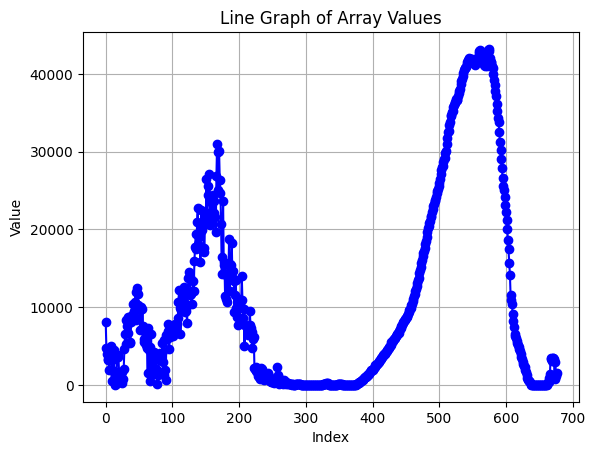

In [24]:

import matplotlib.pyplot as plt

liver_tumors = []
for pred in preds:
    liver_tumors.append(np.sum(pred))
# Example array of values
values = liver_tumors

# x-axis: index of each value
indices = list(range(len(values)))

# Plot the line graph
plt.plot(indices, values, marker='o', linestyle='-', color='b')

# Labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Graph of Array Values")
plt.grid(True)
plt.show()


In [107]:
import numpy as np

def keep_largest_region(preds, pixel_threshold=300):
    """
    Keep only the largest contiguous region of slices with significant predictions.
    
    Args:
        preds: list or np.ndarray of 2D predictions, shape (num_slices, H, W)
        pixel_threshold: minimum number of predicted pixels in a slice to be considered significant
    
    Returns:
        np.ndarray of the same shape as preds, with slices outside the largest region zeroed.
    """
    preds = np.array(preds)
    
    # Count number of predicted pixels in each slice
    counts = np.array([np.sum((pred > 0.5).astype(np.float32)) for pred in preds])
    
    # Mark slices with enough predicted pixels
    mask = counts > pixel_threshold
    
    # Find contiguous True regions
    contiguous_regions = []
    start = None
    for i, val in enumerate(mask):
        if val and start is None:
            start = i
        elif not val and start is not None:
            contiguous_regions.append((start, i-1))
            start = None
    if start is not None:
        contiguous_regions.append((start, len(mask)-1))
    
    if not contiguous_regions:
        # No slice passes threshold, return all zeros
        return np.zeros_like(preds)
    
    # Find the largest contiguous region
    largest_region = max(contiguous_regions, key=lambda x: x[1]-x[0])
    start_idx, end_idx = largest_region
    
    # Zero out slices outside the largest region
    cleared_preds = np.zeros_like(preds)
    cleared_preds[start_idx:end_idx+1] = preds[start_idx:end_idx+1]
    
    return cleared_preds


In [109]:
def keep_largest_component(mask):
    # mask: 2D binary (0/1) numpy array
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask.astype(np.uint8))
    if num_labels <= 1:
        return mask  # nothing to remove
    # stats[1:, cv2.CC_STAT_AREA] gives area of each component except background
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    cleaned_mask = (labels == largest_label).astype(np.float32)
    return cleaned_mask

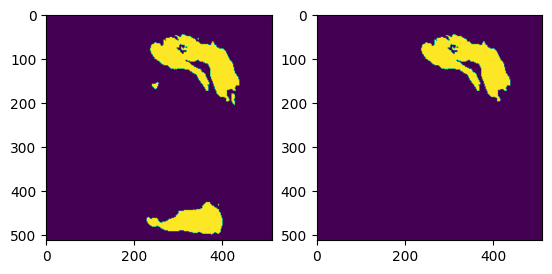

In [38]:
preds_clean =  keep_largest_component(preds[150])
plt.subplot(1,2,1)
plt.imshow(preds[150])
plt.subplot(1,2,2)
plt.imshow(preds_clean)

In [27]:
preds_cleared = keep_largest_region(preds)

In [28]:
liver_tumors_cleared = []
for pred in preds_cleared:
    pred = (pred > 0.5).astype(np.float32)
    liver_tumors_cleared.append(np.sum(pred))

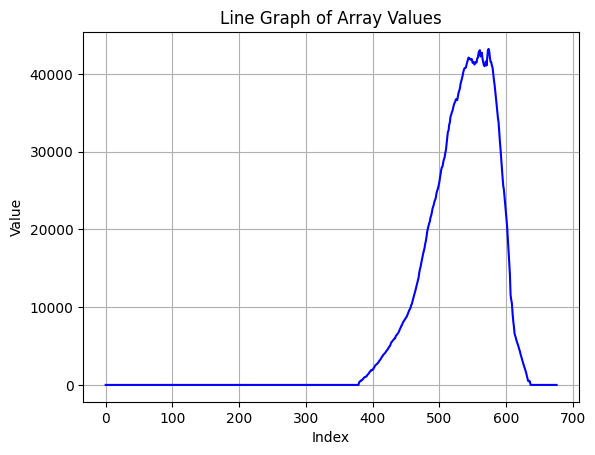

In [29]:

import matplotlib.pyplot as plt

# Example array of values
values = liver_tumors_cleared

# x-axis: index of each value
indices = list(range(len(values)))

# Plot the line graph
plt.plot(indices, values, linestyle='-', color='b')

# Labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Graph of Array Values")
plt.grid(True)
plt.show()


In [117]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
